In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
df = pd.read_csv('/content/IMDB_10K.csv')
df = df[['review','sentiment']].dropna().reset_index(drop=True)
def clean_text(text):
    text = str(text)
    text = re.sub(r'<.*?>',' ', text)
    text = text.lower()
    text = re.sub(r'[^a-z\s]',' ', text)
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words and len(t)>1]
    return ' '.join(tokens)
df['clean_text'] = df['review'].apply(clean_text)
df.to_csv('IMDB_10K_CLEAN.csv', index=False)
print('saved IMDB_10K_CLEAN.csv', df.shape)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


saved IMDB_10K_CLEAN.csv (9999, 3)


Topic Modeling Implementation

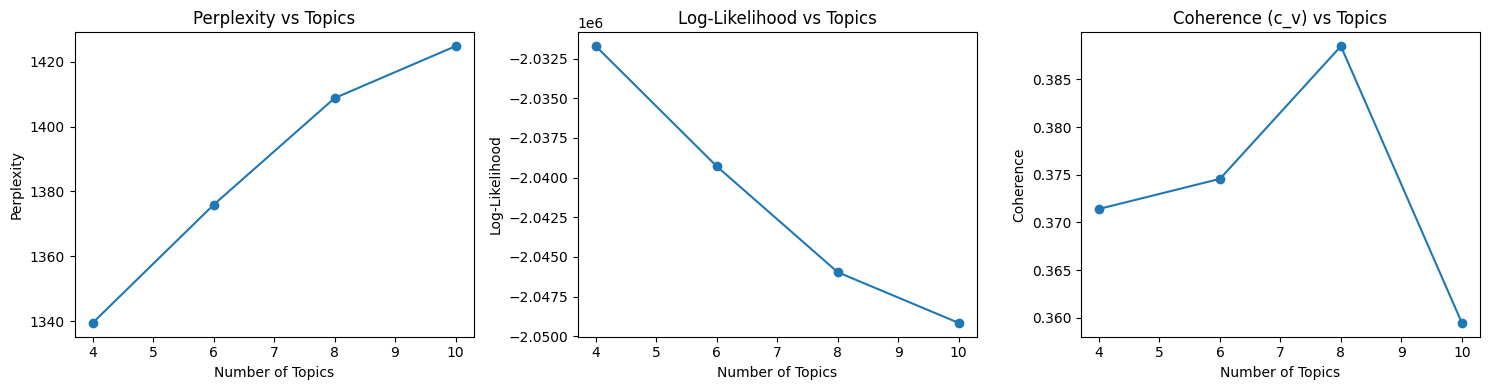

Topic 0 : movie, show, like, really, people, one, would, watch, see, think, even, thing, get, bad, good
Topic 1 : film, life, war, story, character, human, man, world, one, also, men, many, two, woman, work
Topic 2 : best, musical, song, oscar, band, lee, prison, great, award, rock, charlie, number, kelly, johnny, holmes
Topic 3 : film, one, like, scene, make, time, even, character, horror, get, much, see, would, story, look
Topic 4 : movie, film, one, good, like, time, character, story, great, well, make, would, even, see, actor
Topic 5 : one, mr, doctor, original, john, disney, king, best, dr, stewart, evil, three, star, man, series
Topic 6 : city, police, murder, cop, crime, de, world, street, boy, get, york, new, night, jason, officer
Topic 7 : family, mother, young, wife, woman, man, child, father, life, daughter, son, dog, home, husband, love


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('IMDB_10K_CLEAN.csv')
df_sample = df.sample(3000, random_state=42)
texts = [t.split() for t in df_sample['clean_text'].astype(str).tolist()]
dictionary = Dictionary(texts)

vectorizer = CountVectorizer(max_df=0.90, min_df=10, max_features=3000)
X = vectorizer.fit_transform(df_sample['clean_text'].astype(str))

def get_top_words_from_components(components, feature_names, n_top):
    topics = []
    for comp in components:
        top_idx = comp.argsort()[-n_top:][::-1]
        topics.append([feature_names[i] for i in top_idx])
    return topics

n_topics_list = [4,6,8,10]
perplexities = []
log_likelihoods = []
coherences = []
feature_names = vectorizer.get_feature_names_out()

for n_topics in n_topics_list:
    model = LatentDirichletAllocation(n_components=n_topics, max_iter=5, learning_method='online', batch_size=128, random_state=42)
    model.fit(X)
    perp = model.perplexity(X)
    ll = model.score(X)
    comps = model.components_
    topics_words = get_top_words_from_components(comps, feature_names, 12)
    cm = CoherenceModel(topics=topics_words, texts=texts, dictionary=dictionary, coherence='c_v')
    coh = cm.get_coherence()
    perplexities.append(perp)
    log_likelihoods.append(ll)
    coherences.append(coh)

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(n_topics_list, perplexities, marker='o')
plt.title('Perplexity vs Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.subplot(1,3,2)
plt.plot(n_topics_list, log_likelihoods, marker='o')
plt.title('Log-Likelihood vs Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Log-Likelihood')
plt.subplot(1,3,3)
plt.plot(n_topics_list, coherences, marker='o')
plt.title('Coherence (c_v) vs Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.tight_layout()
plt.show()

best_idx = int(np.argmax(coherences))
best_n = n_topics_list[best_idx]
best_model = LatentDirichletAllocation(n_components=best_n, max_iter=10, learning_method='online', batch_size=128, random_state=42)
best_model.fit(X)
best_components = best_model.components_
top_words = get_top_words_from_components(best_components, feature_names, 15)

for i, t in enumerate(top_words):
    print('Topic', i, ':', ', '.join(t))

Sentiment Analysis

Epoch 1: Train Loss=0.6607, Dev Loss=0.6617, Train Acc=0.8471, Dev Acc=0.8345
Epoch 2: Train Loss=0.6327, Dev Loss=0.6346, Train Acc=0.8517, Dev Acc=0.8405
Epoch 3: Train Loss=0.6083, Dev Loss=0.6111, Train Acc=0.8555, Dev Acc=0.8435
Epoch 4: Train Loss=0.5869, Dev Loss=0.5905, Train Acc=0.8567, Dev Acc=0.8475
Epoch 5: Train Loss=0.5681, Dev Loss=0.5724, Train Acc=0.8589, Dev Acc=0.8485
Epoch 6: Train Loss=0.5513, Dev Loss=0.5564, Train Acc=0.8604, Dev Acc=0.8500
Epoch 7: Train Loss=0.5363, Dev Loss=0.5421, Train Acc=0.8622, Dev Acc=0.8500
Epoch 8: Train Loss=0.5228, Dev Loss=0.5293, Train Acc=0.8644, Dev Acc=0.8545
Epoch 9: Train Loss=0.5106, Dev Loss=0.5178, Train Acc=0.8666, Dev Acc=0.8570
Epoch 10: Train Loss=0.4995, Dev Loss=0.5073, Train Acc=0.8689, Dev Acc=0.8580
Epoch 11: Train Loss=0.4893, Dev Loss=0.4978, Train Acc=0.8697, Dev Acc=0.8590
Epoch 12: Train Loss=0.4800, Dev Loss=0.4892, Train Acc=0.8715, Dev Acc=0.8595
Epoch 13: Train Loss=0.4715, Dev Loss=0.4812, Train Acc=0.873

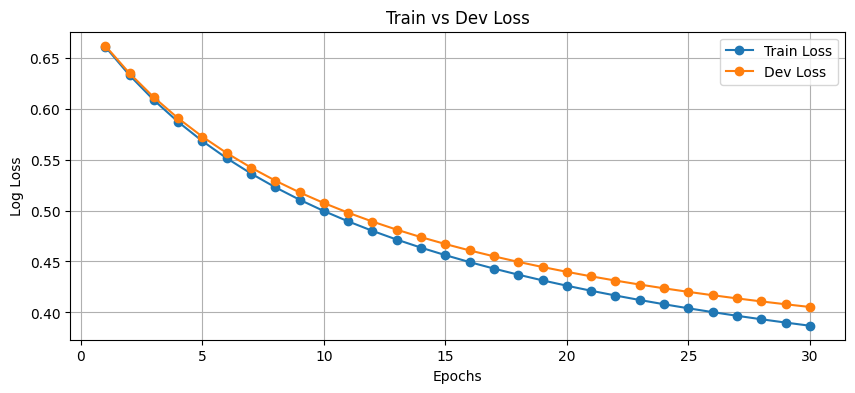

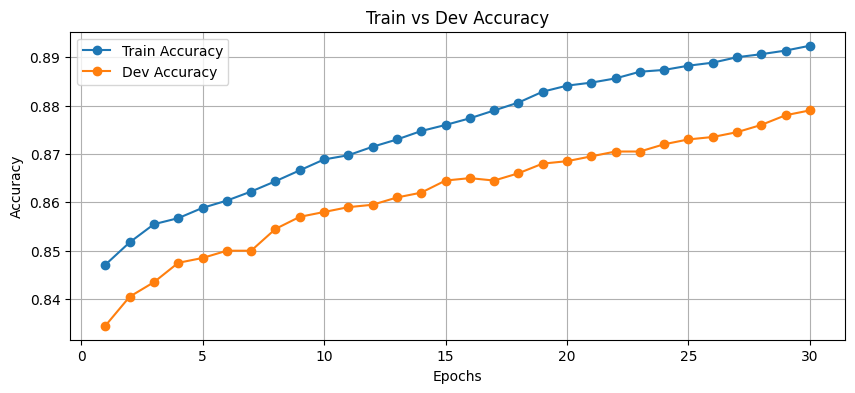

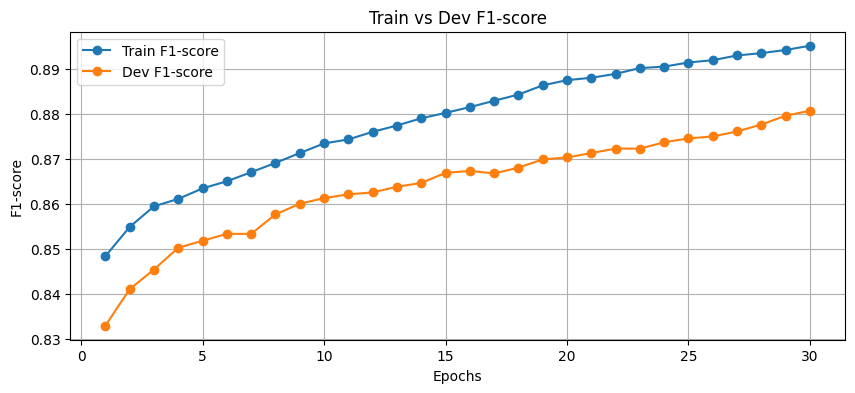

Final Evaluation on Dev Set
Final Log Loss: 0.4054
Final Accuracy: 0.8790
Final F1-score: 0.8808
              precision    recall  f1-score   support

    negative     0.8852    0.8692    0.8772       994
    positive     0.8730    0.8887    0.8808      1006

    accuracy                         0.8790      2000
   macro avg     0.8791    0.8789    0.8790      2000
weighted avg     0.8791    0.8790    0.8790      2000

Saved IMDB_10K_SGD_SENTIMENT.csv


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss, accuracy_score, f1_score, classification_report
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

df = pd.read_csv('IMDB_10K_CLEAN.csv')
df_eval = df[df['sentiment'].isin(['positive','negative'])].copy()
X = df_eval['clean_text'].astype(str).tolist()
y = df_eval['sentiment'].tolist()

le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_dev, y_train, y_dev = train_test_split(X, y_enc, test_size=0.2, random_state=42, stratify=y_enc)

vectorizer = TfidfVectorizer(max_df=0.90, min_df=5, max_features=5000, ngram_range=(1,2))
X_train_vec = vectorizer.fit_transform(X_train)
X_dev_vec = vectorizer.transform(X_dev)

train_losses, dev_losses = [], []
train_accs, dev_accs = [], []
train_f1s, dev_f1s = [], []

clf = SGDClassifier(loss='log_loss', max_iter=1, learning_rate='constant', eta0=0.01,
                    random_state=42, warm_start=True)

for epoch in range(1, 31):
    clf.fit(X_train_vec, y_train)

    y_train_prob = clf.predict_proba(X_train_vec)
    y_dev_prob = clf.predict_proba(X_dev_vec)
    y_train_pred = clf.predict(X_train_vec)
    y_dev_pred = clf.predict(X_dev_vec)

    train_loss = log_loss(y_train, y_train_prob)
    dev_loss = log_loss(y_dev, y_dev_prob)
    train_acc = accuracy_score(y_train, y_train_pred)
    dev_acc = accuracy_score(y_dev, y_dev_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    dev_f1 = f1_score(y_dev, y_dev_pred)

    train_losses.append(train_loss)
    dev_losses.append(dev_loss)
    train_accs.append(train_acc)
    dev_accs.append(dev_acc)
    train_f1s.append(train_f1)
    dev_f1s.append(dev_f1)

    print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Dev Loss={dev_loss:.4f}, "
          f"Train Acc={train_acc:.4f}, Dev Acc={dev_acc:.4f}")

plt.figure(figsize=(10,4))
plt.plot(range(1,31), train_losses, label='Train Loss', marker='o')
plt.plot(range(1,31), dev_losses, label='Dev Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('Train vs Dev Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(range(1,31), train_accs, label='Train Accuracy', marker='o')
plt.plot(range(1,31), dev_accs, label='Dev Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Dev Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(range(1,31), train_f1s, label='Train F1-score', marker='o')
plt.plot(range(1,31), dev_f1s, label='Dev F1-score', marker='o')
plt.xlabel('Epochs')
plt.ylabel('F1-score')
plt.title('Train vs Dev F1-score')
plt.legend()
plt.grid(True)
plt.show()

y_pred_final = clf.predict(X_dev_vec)
y_prob_final = clf.predict_proba(X_dev_vec)

final_loss = log_loss(y_dev, y_prob_final)
final_acc = accuracy_score(y_dev, y_pred_final)
final_f1 = f1_score(y_dev, y_pred_final)

print("Final Evaluation on Dev Set")
print(f"Final Log Loss: {final_loss:.4f}")
print(f"Final Accuracy: {final_acc:.4f}")
print(f"Final F1-score: {final_f1:.4f}")
print(classification_report(y_dev, y_pred_final, target_names=le.classes_, digits=4))

df_eval['sgd_sentiment'] = le.inverse_transform(clf.predict(vectorizer.transform(df_eval['clean_text'].astype(str))))
df_eval.to_csv('IMDB_10K_SGD_SENTIMENT.csv', index=False)
print('Saved IMDB_10K_SGD_SENTIMENT.csv')


 Visualization

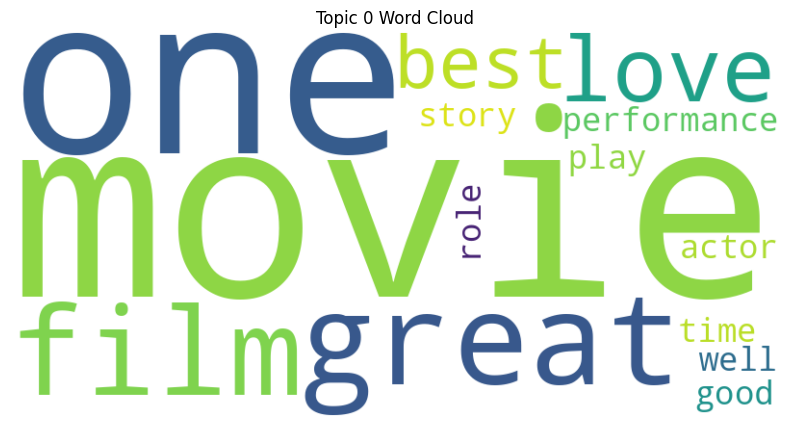

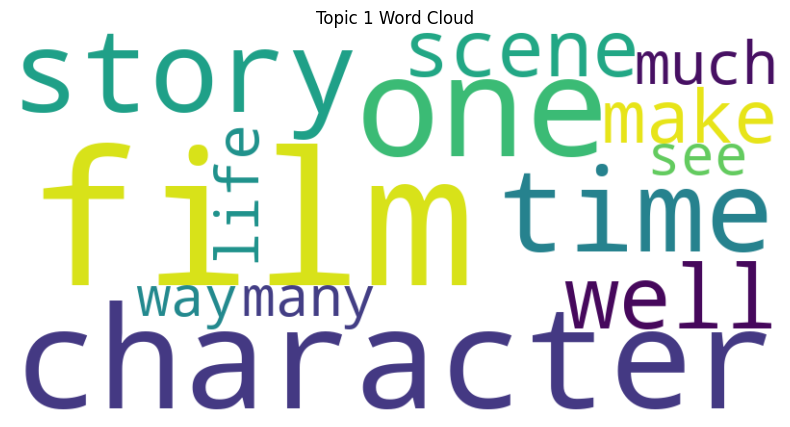

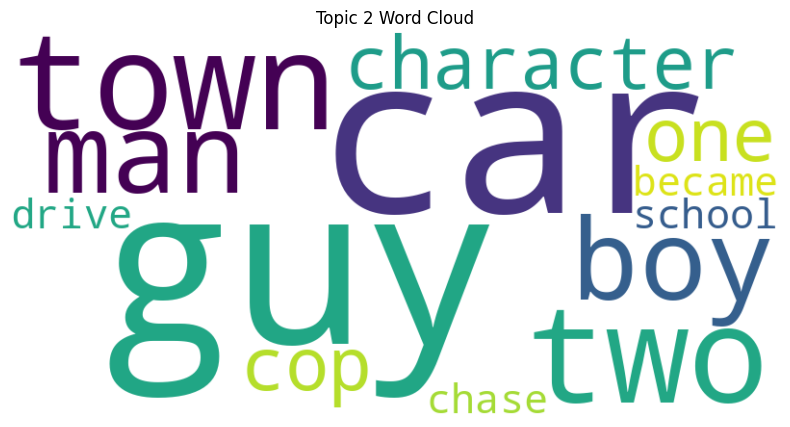

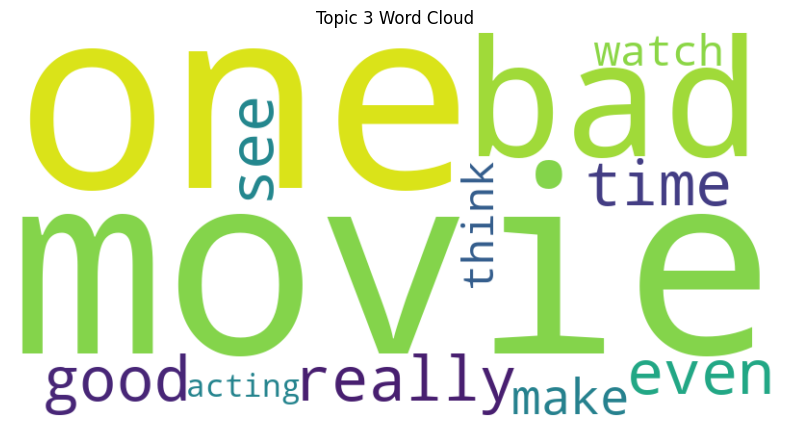

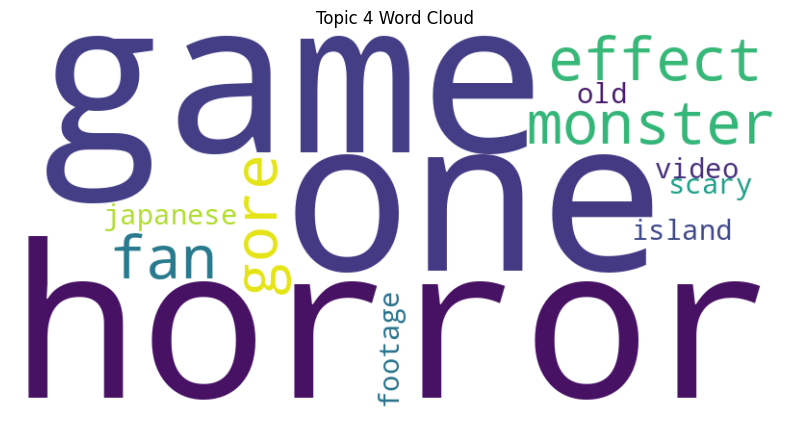

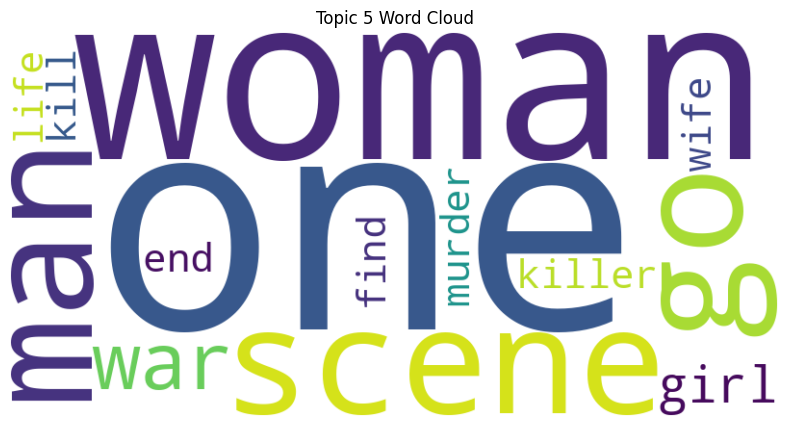

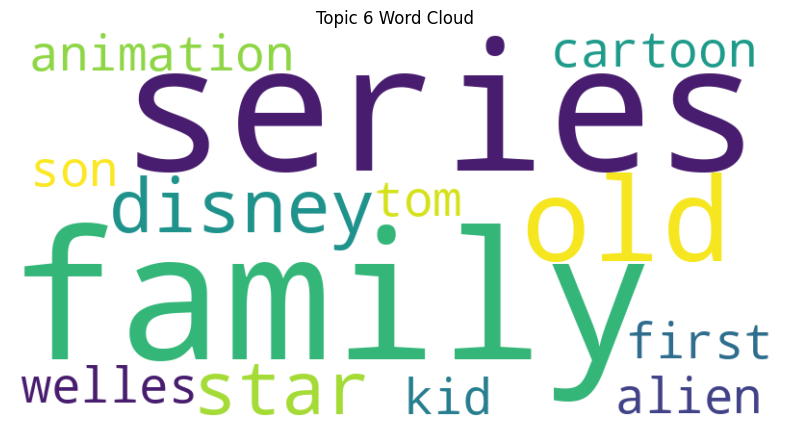

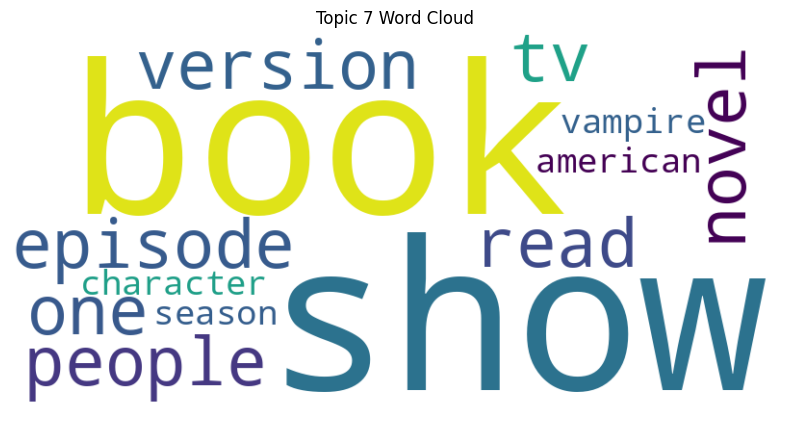

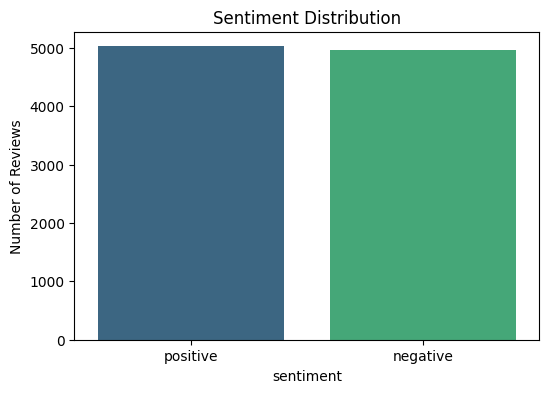

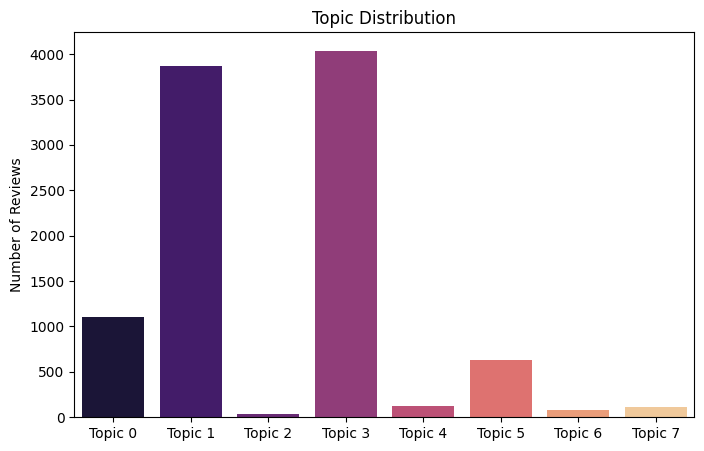

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np

df = pd.read_csv('IMDB_10K_CLEAN.csv')
df_sent = pd.read_csv('IMDB_10K_SGD_SENTIMENT.csv')

sent_col = None
for col in df_sent.columns:
    if 'sentiment' in col.lower():
        sent_col = col
        break

vectorizer = CountVectorizer(max_df=0.90, min_df=10, max_features=3000)
X = vectorizer.fit_transform(df['clean_text'].astype(str))
n_topics = 8
lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=10, learning_method='online', random_state=42)
lda_model.fit(X)
feature_names = vectorizer.get_feature_names_out()

def get_top_words_from_components(components, feature_names, n_top):
    topics = []
    for comp in components:
        top_idx = comp.argsort()[-n_top:][::-1]
        topics.append([feature_names[i] for i in top_idx])
    return topics

top_words = get_top_words_from_components(lda_model.components_, feature_names, 15)

for i, words in enumerate(top_words):
    text = ' '.join(words)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic {i} Word Cloud')
    plt.show()

if sent_col:
    sent_counts = df_sent[sent_col].value_counts()
    plt.figure(figsize=(6,4))
    sns.barplot(x=sent_counts.index, y=sent_counts.values, palette='viridis')
    plt.ylabel('Number of Reviews')
    plt.title('Sentiment Distribution')
    plt.show()

topic_distribution = lda_model.transform(X)
topic_labels = [f'Topic {i}' for i in range(n_topics)]
topic_counts = np.argmax(topic_distribution, axis=1)
plt.figure(figsize=(8,5))
sns.countplot(x=topic_counts, palette='magma')
plt.xticks(ticks=range(n_topics), labels=topic_labels)
plt.ylabel('Number of Reviews')
plt.title('Topic Distribution')
plt.show()


In [14]:
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import torch
from transformers import pipeline

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

df = pd.read_csv('IMDB_10K_CLEAN.csv')

vectorizer = CountVectorizer(max_df=0.90, min_df=10, max_features=3000)
X = vectorizer.fit_transform(df['clean_text'].astype(str))

n_topics = 8
lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=10, learning_method='online', random_state=42)
lda_model.fit(X)

N_TOP_DOCS_PER_TOPIC = 70
MAX_SENTS_PER_DOC = 2
EXTRACTIVE_SUMMARY_SENTS = 4
MIN_ABS_LEN = 25
MAX_ABS_LEN = 80
TRIGRAM_OVERLAP_MAX = 0.5

stop_words = set(stopwords.words('english'))

def doc_topic_matrix(lda_model, X):
    return lda_model.transform(X)

def top_docs_for_topic(doc_topic, topic_id, top_k):
    scores = doc_topic[:, topic_id]
    return np.argsort(-scores)[:top_k]

def trigrams(s):
    words = [w for w in s.split() if w.isalpha()]
    return set(zip(words, words[1:], words[2:])) if len(words) >= 3 else set()

def redundant(a, b, thr=TRIGRAM_OVERLAP_MAX):
    A, B = trigrams(a), trigrams(b)
    if not A or not B:
        return False
    inter = len(A & B)
    denom = max(len(A), 1)
    return (inter / denom) > thr

def collect_topic_sentences(df, doc_indices, max_sents_per_doc=2):
    sentences = []
    for idx in doc_indices:
        text = str(df.iloc[idx]['clean_text'])
        sents = [s.strip() for s in sent_tokenize(text) if len(s.strip().split()) >= 6]
        if not sents:
            sents = [s.strip() for s in text.split('.') if len(s.strip().split()) >= 6]
        if sents:
            sentences.extend(sents[:max_sents_per_doc])
    seen = set()
    uniq = []
    for s in sentences:
        if s not in seen:
            uniq.append(s)
            seen.add(s)
    return uniq

def score_sentences_extractive(sentences):
    if not sentences:
        return []
    text_all = " ".join(sentences)
    words = [w.lower() for w in text_all.split() if w.isalpha() and w.lower() not in stop_words]
    if not words:
        return list(range(min(len(sentences), EXTRACTIVE_SUMMARY_SENTS)))
    freq = FreqDist(words)
    scores = []
    for i, s in enumerate(sentences):
        score = sum(freq[w.lower()] for w in s.split() if w.isalpha())
        scores.append((score, i))
    scores.sort(reverse=True, key=lambda x: x[0])
    ranked_idx = [i for _, i in scores]
    selected = []
    for i in ranked_idx:
        if len(selected) >= EXTRACTIVE_SUMMARY_SENTS:
            break
        if all(not redundant(sentences[i], sentences[j]) for j in selected):
            selected.append(i)
    if not selected:
        selected = ranked_idx[:EXTRACTIVE_SUMMARY_SENTS]
    return sorted(selected)

def build_extractive_summary_for_topic(df, doc_topic, topic_id, top_k_docs=N_TOP_DOCS_PER_TOPIC):
    doc_idx = top_docs_for_topic(doc_topic, topic_id, top_k_docs)
    sentences = collect_topic_sentences(df, doc_idx, max_sents_per_doc=MAX_SENTS_PER_DOC)
    if not sentences:
        return ""
    selected_idx = score_sentences_extractive(sentences)
    summary_sents = [sentences[i] for i in selected_idx]
    return " ".join(summary_sents)

device = 0 if torch.cuda.is_available() else -1
summarizer = pipeline('summarization', model='t5-small', tokenizer='t5-small', device=device)

def abstractive_summarize(text, min_len=MIN_ABS_LEN, max_len=MAX_ABS_LEN):
    raw = (text or "").strip()
    if not raw:
        return ""
    if len(raw.split()) < 25:
        raw = "This topic is about: " + raw
    prefixed = "summarize: " + raw[:2000]
    try:
        out = summarizer(
            prefixed,
            max_length=max_len,
            min_length=min_len,
            num_beams=6,
            no_repeat_ngram_size=3,
            repetition_penalty=1.2,
            length_penalty=1.0,
            do_sample=False,
            truncation=True
        )[0]['summary_text']
        return out.strip()
    except Exception:
        return raw.strip()

doc_topic = doc_topic_matrix(lda_model, X)
topic_ids = list(range(n_topics))
extractive_summaries = []
abstractive_summaries = []

for k in topic_ids:
    ext = build_extractive_summary_for_topic(df, doc_topic, k, top_k_docs=N_TOP_DOCS_PER_TOPIC)
    abs_sum = abstractive_summarize(ext, min_len=MIN_ABS_LEN, max_len=MAX_ABS_LEN)
    extractive_summaries.append(ext)
    abstractive_summaries.append(abs_sum)

topic_labels = [f"Topic {i}" for i in topic_ids]
out_df = pd.DataFrame({"topic": topic_labels, "extractive_summary": extractive_summaries, "abstractive_summary": abstractive_summaries})
out_df.to_csv("TOPIC_SUMMARIES_FINAL.csv", index=False)
print("Saved TOPIC_SUMMARIES_FINAL.csv")


Device set to use cpu
Both `max_new_tokens` (=256) and `max_length`(=80) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=80) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=80) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=80) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes

Saved TOPIC_SUMMARIES_FINAL.csv
